In this notebook we will train a basic keras neural network.

The dataset will be small and use very little feature engineering.

The prediction target will be 0 or 1.
* 0 = the player did not win the race
* 1 = the player won the race

We will save the model along with the dummies and scaling params.

We will then load the model and apply it to the validation data.

Finally we will graph the betting results based on the predictions.

In [1]:
import pandas as pd
import numpy as np
import tensorflow

from cataclop.core import models
from cataclop.ml.preprocessing import append_hist, model_to_dict
from cataclop.ml.preprocessing import get_dummies, get_dummy_values, get_dummy_features
from cataclop.ml.exploration import random_race

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

Load up to 10000 races from the database

In [2]:
races = models.Race.objects.all().prefetch_related('player_set', 'session', 'session__hippodrome')

races = races.filter(
    #session__hippodrome__country__in=('FRA',),
    #category__in=('PLAT',),
    #sub_category__in=('HANDICAP',),
    start_at__gte='2021-01-01',
    start_at__lt='2021-02-01'
)

races = races[:10000]

hippodromes = models.Hippodrome.objects.all()
hippodromes = [ model_to_dict(hippo) for hippo in hippodromes ]

sessions = [race.session for race in races]
sessions = list( map(lambda s: model_to_dict(s), set(sessions)) )

def player_dict(p):
    d = model_to_dict(p)
    d.update({
        "horse_name": p.horse.name,
        "horse_breed": p.horse.breed,
        "horse_sex": p.horse.sex
    })
    return d
players = [ player_dict(p) for race in races for p in race.player_set.all() ]

races = [ model_to_dict(race) for race in races ]

print('{} races'.format(len(races)))

1322 races


Construct the dataframe

In [3]:
races_df = pd.DataFrame.from_records(races, index='id')
sessions_df = pd.DataFrame.from_records(sessions, index='id')
hippodromes_df = pd.DataFrame.from_records(hippodromes, index='id')
players_df = pd.DataFrame.from_records(players, index='id')

hippodromes_df.index.name = "hippodrome_id"
sessions_df.index.name = "session_id"
races_df.index.name = "race_id"

# optimize a bit the dataframe
for c in ['horse_breed', 'horse_sex']:
    players_df[c] = players_df[c].astype('category')

for c in ['category', 'condition_age', 'condition_sex', 'sub_category']:
    races_df[c] = races_df[c].astype('category')

for c in ['country']:
    hippodromes_df[c] = hippodromes_df[c].astype('category')

# join all the dataframes into one
sessions_df = sessions_df.join(hippodromes_df, on="hippodrome_id", lsuffix="_session", rsuffix="_hippo")
races_df = races_df.join(sessions_df, on="session_id", lsuffix="_race", rsuffix="_session")

df = players_df.join(races_df, on="race_id", lsuffix="_player", rsuffix="_race")

df.reset_index(inplace=True)
df.set_index(['id'], inplace=True)

df['winner_dividend'].fillna(0., inplace=True)
df['placed_dividend'].fillna(0., inplace=True)

NUM_HIST = 6
# append 6 columns of position history (hist_1_pos, hist_2_pos...)
# parse the horse 'musique' into those columns
# eg. '1a4a7d0' : hist_1_pos=1, hist_2_pos=4, hist_3_pos=7, hist_4_pos=10
df = append_hist(df, NUM_HIST)

df['victory_earnings'] = np.log(1+df['victory_earnings'].fillna(0))
df['placed_earnings'] = np.log(1+df['placed_earnings'].fillna(0))
df['prev_year_earnings'] = np.log(1+df['prev_year_earnings'].fillna(0))
df['year_earnings'] = np.log(1+df['year_earnings'].fillna(0))
df['prize'] = np.log(df['prize'].fillna(0)+1)

df['handicap_distance'] = df['handicap_distance'].fillna(0.0)
df['handicap_weight'] = df['handicap_weight'].fillna(0.0)
df['win'] = (df['position'] == 1).astype(np.float)

In [4]:
sorted(list(df.columns))

['age',
 'category',
 'code',
 'condition_age',
 'condition_sex',
 'country',
 'date',
 'declared_player_count',
 'distance',
 'earnings',
 'final_odds',
 'final_odds_offline',
 'final_odds_ref',
 'final_odds_ref_offline',
 'final_odds_ref_unibet',
 'final_odds_unibet',
 'handicap_distance',
 'handicap_weight',
 'herder_avg_winning_dividend',
 'herder_id',
 'herder_winning_rate',
 'hippodrome_id',
 'hist_1_days',
 'hist_1_pos',
 'hist_2_days',
 'hist_2_pos',
 'hist_3_days',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'horse_breed',
 'horse_id',
 'horse_name',
 'horse_sex',
 'imported_at_hippo',
 'imported_at_player',
 'imported_at_race',
 'imported_at_session',
 'is_first_timer',
 'is_racing',
 'jockey_avg_winning_dividend',
 'jockey_change',
 'jockey_id',
 'jockey_winning_rate',
 'music',
 'name',
 'num',
 'num_bis',
 'num_race',
 'num_session',
 'owner_id',
 'placed_2_count',
 'placed_3_count',
 'placed_count',
 'placed_dividend',
 'placed_dividend_offline',
 'placed

In [5]:
df.describe()

,race_id,age,num,race_count,victory_count,placed_count,placed_2_count,placed_3_count,earnings,victory_earnings,placed_earnings,year_earnings,prev_year_earnings,post_position,position,handicap_weight,handicap_distance,trueskill_mu,trueskill_sigma,time,hist_1_days,hist_2_days,hist_3_days,winner_dividend,placed_dividend,final_odds,final_odds_offline,final_odds_unibet,final_odds_ref,final_odds_ref_offline,final_odds_ref_unibet,trainer_winning_rate,trainer_avg_winning_dividend,horse_id,trainer_id,jockey_id,herder_id,owner_id,num_race,num_bis,prize,distance,declared_player_count,session_id,num_session,hippodrome_id,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,win
count,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,1.596500e+04,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,12762.000000,15965.000000,15965.000000,15965.000000,15965.000000,5543.000000,3686.000000,580.000000,59.000000,15965.000000,15965.000000,15638.000000,12045.000000,14900.000000,15045.000000,11536.000000,14932.000000,12790.000000,12790.000000,15965.000000,15965.000000,15965.000000,10156.000000,15965.000000,15965.000000,1261.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000
mean,655.999937,5.561353,6.916317,24.382336,2.684685,10.617413,2.534168,2.384341,6.563772e+06,13.682499,11.649797,3.136052,10.764135,6.916317,5.861856,10.664579,1233.414344,25.158988,7.100542,195685.515064,12.136734,18.087931,21.813559,70.419042,72.434075,33.504786,34.136306,30.989839,24.144905,22.653450,27.105391,0.082549,-0.280415,5347.393486,857.651989,687.350642,1118.386963,2722.651550,4.877231,1.762887,9.668022,2181.362668,12.832634,95.323833,3.523019,15.235954,6.272972,5.945506,5.686940,5.003069,3.970122,3.367742,0.082242
std,383.020154,1.862862,4.049526,26.469777,3.388455,11.794345,3.112589,2.943889,1.375487e+07,4.134910,5.613142,5.451706,5.910035,4.049526,3.546344,16.475917,1300.725431,3.950268,2.211882,26942.929276,5.638333,5.061029,4.183195,405.321321,191.615665,48.193140,43.208026,39.553740,33.453339,24.000108,34.197496,0.156142,2.141056,3415.399644,725.175253,555.417193,908.818094,2098.225265,2.536990,0.772598,1.100038,729.140942,2.876507,55.398042,1.910796,13.245377,3.275407,3.396984,3.494307,3.717243,3.909612,3.815709,0.274742
min,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.529207,1.038827,24980.000000,1.000000,2.000000,13.000000,0.000000,0.000000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,0.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.459904,800.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,323.000000,4.000000,4.000000,5.000000,0.000000,2.000000,0.000000,0.000000,6.852000e+05,13.437468,11.931642,0.000000,10.926658,4.000000,3.000000,0.000000,0.000000,25.000000,8.333333,168440.000000,8.000000,15.000000,19.000000,0.000000,0.000000,7.400000,7.700000,7.300000,7.700000,8.100000,7.600000,0.000000,-1.000000,2384.000000,253.000000,219.000000,356.000000,885.000000,3.000000,1.000000,9.049819,1600.000000,11.000000,47.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,650.000000,5.000000,7.000000,16.000000,2.000000,7.000000,2.000000,1.000000,2.553000e+06,14.752780,13.907179,0.000000,13.503537,7.000000,5.000000,0.000000,0.000000,25.000000,8.333333,204550.000000,12.000000,18.000000,22.000000,0.000000,0.000000,16.000000,17.000000,15.800000,14.000000,15.000000,15.100000,0.000000,-1.000000,5056.000000,686.000000,600.000000,861.000000,2251.000000,5.000000,2.000000,9.798183,2150.000000,13.000000,95.000000,3.000000,14.000000,6.000000,6.000000,6.000000,5.000000,3.000000,2.000000,0.000000
75%,985.000000,7.000000,10.000000,35

Define the target and the features to feed our model 

In [6]:
TARGET = 'win'

FEATURES = [
    'race_count',
    'victory_count',
    'placed_count',
    'placed_2_count',
    'placed_3_count',
    'prize',
    'declared_player_count', 
    'age', 
    'earnings',
    'victory_earnings', 
    'placed_earnings', 
    'post_position',
    'handicap_weight',
    'handicap_distance'
] + ['hist_{}_pos'.format(h+1) for h in range(NUM_HIST)]

CATEGORICAL_FEATURES = [
    'category', 
    'sub_category', 
    'horse_breed',
    'horse_sex'
]

# what I do before fine tuning the model is to inject the target into the features
# the model should pick it up and get REALLY good predictions
# uncomment the following line to test it
# FEATURES += [TARGET]

FEATURES + CATEGORICAL_FEATURES

['race_count',
 'victory_count',
 'placed_count',
 'placed_2_count',
 'placed_3_count',
 'prize',
 'declared_player_count',
 'age',
 'earnings',
 'victory_earnings',
 'placed_earnings',
 'post_position',
 'handicap_weight',
 'handicap_distance',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'category',
 'sub_category',
 'horse_breed',
 'horse_sex']

Show selected features for one race

In [7]:
random_race(df, [TARGET, 'num', 'final_odds', 'music', 'position'] + FEATURES + CATEGORICAL_FEATURES).sort_values('position')

win  num  final_odds                   music  position  \
race_id id                                                              
1176    14217  1.0    7         5.4  (20)0aDa6a8a0aDaDa6a9a       1.0   
        14219  0.0    9         5.5  3a0a(20)2a8a5a9a6a5a3a       2.0   
        14224  0.0   14        23.0    (20)5aDaDa3a5a4a1aDa       3.0   
        14226  0.0   16        11.0  (20)0a8a4a1a7a0a1a8a0a       4.0   
        14211  0.0    1        80.0    (20)5aDa7a5a4aDa5a3a       5.0   
        14220  0.0   10        50.0  0a(20)9a9a4a8a3a5aDa1a       6.0   
        14212  0.0    2        21.0  6a(20)0a3a0a8aDa2a5aDa       7.0   
        14218  0.0    8         9.8  0a(20)3a0a3a6a0a7a6a4a       8.0   
        14214  0.0    4        79.0  (20)DaDa0m5a5aDaDa2a3a       9.0   
        14223  0.0   13       135.0    (20)8a8a0a9aDaDa5a5a      10.0   
        14213  0.0    3        19.0  (20)0a6aDaDa8a3a0a8aDa       NaN   
        14215  0.0    5        20.0  Da(20)4a7a6a8a8a3a5a8a       NaN   
        14216  0.0    6        10.0  Da(20)Da2a0a3a0aDaDa7a       NaN   
        14221  0.0   11        20.0  0a(20)0aDa3a3a4a3a6aDa       NaN   
        14222  0.0   12       304.0          (20)0aDa(19)Da       NaN   
        14225  0.0   15         6.9  Da4a(20)Da4a1a3aDa3aDa       NaN   
        14227  0.0   17        11.0  4a(20)9aDmDa4a8a3a8a8a       NaN   
        14228  0.0   18        10.0  Da(20)DaDa0a9a6a8aDa1a       NaN   

               race_count  victory_count  placed_count  placed_2_count  \
race_id id                                                               
1176    14217          30              1             9               0   
        14219          24              1            13               2   
        14224          15              1             6               0   
        14226          11              3             3               0   
        14211          14              0            12               0   
        14220          19              1            10               1   
        14212          19              0            10               1   
        14218          21              1            12               1   
        14214          15              0             6               2   
        14223          16              0             8               1   
        14213          19              1             4               0   
        14215          22              0            17               0   
        14216          15              1             6               1   
        14221          30              3            12               0   
        14222           3              0             0               0   
        14225          19              1             8               1   
        14227          30              2            11               1   
        14228          29              3            11               3   

               placed_3_count     prize  declared_player_count  age  earnings  \
race_id id                                                                      
1176    14217               3  9.392745                     18    5   1524000   
        14219               3  9.392745                     18    5   1828000   
        14224               1  9.392745                     18    5   1027000   
        14226               0  9.392745                     18    5   1742000   
        14211               1  9.392745                     18    5    727000   
        14220               3  9.392745                     18    5   1858000   
        14212               1  9.392745                     18    5    943000   
        14218               2  9.392745                     18    5   1661000   
        14214               2  9.392745                     18    5   1027000   
        14223               0  9.392745                     18    5    567000   
        14213               1  9.392745                     18    5    983000   
        14215       

Split our dataset into a training set and validation set

In [8]:
df_model = df[~df[TARGET].isna()].copy()
df_model['pred'] = 0
df_model['pred_prob'] = 0.
df_model['profit'] = 0.

race_ids = df_model['race_id'].unique()

# keep 1/5 of the dataset for validation
VALIDATION_NUM_SAMPLES = int(len(race_ids)/5)
race_ids_validation = race_ids[:VALIDATION_NUM_SAMPLES]
race_ids_train = race_ids[VALIDATION_NUM_SAMPLES:]

df_validation = df_model[df_model['race_id'].isin(race_ids_validation)].copy()
df_train = df_model[df_model['race_id'].isin(race_ids_train)].copy()

df_train.reset_index(inplace=True)
df_validation.reset_index(inplace=True)

print('{} train samples, {} validation samples'.format(len(df_train), len(df_validation)))

12697 train samples, 3268 validation samples


Check how unbalanced the dataset is

In [9]:
from collections import Counter
Counter(df_train[TARGET])

Counter({0.0: 11648, 1.0: 1049})

Finally train a model on each kfold get the prediction for the other kfolds

In [10]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone as clone
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier, MLPRegressor
from cataclop.ml.keras import KerasRegressor
from xgboost import XGBRegressor

def build_fn_factory(input_dim):
    def baseline_regressor():
        from keras.models import Sequential
        from keras.layers import Dense

        model = Sequential()
        model.add(Dense(100, input_dim=input_dim, activation='tanh'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model
    return baseline_regressor

K_FOLD=2

groups = df_train['race_id'].values
group_kfold = GroupKFold(n_splits=K_FOLD)

splits = list(group_kfold.split(df_train.values, df_train[TARGET].values, groups))

models = []

for train_index, test_index in splits:
    dummies = get_dummies(df_train.iloc[train_index], CATEGORICAL_FEATURES)
    
    X_train = df_train[FEATURES].iloc[train_index].copy()
    y_train = df_train[TARGET].iloc[train_index]
    
    df_dummies = get_dummy_values(df_train.iloc[train_index], dummies)
    X_train = pd.concat([X_train, df_dummies], axis=1)
    
    X_test = df_train[FEATURES].iloc[test_index].copy()
    y_test = df_train[TARGET].iloc[test_index]
    df_dummies = get_dummy_values(df_train.iloc[test_index], dummies)
    X_test = pd.concat([X_test, df_dummies], axis=1)
    
    # filter only the training set
    # train_balanced_idx = ((df_train.iloc[train_index]['position'] == 1) | (df_train.iloc[train_index]['position'] == 2))
    # X_train = X_train.loc[train_balanced_idx]
    # y_train = y_train.loc[train_balanced_idx]
    
    steps = [QuantileTransformer(), KerasRegressor(build_fn=build_fn_factory(X_train.shape[1]), epochs=10, batch_size=32, verbose=True)]
    
    X_train = X_train.values
    X_test = X_test.values
    
    pipeline = make_pipeline(*steps)
    pipeline.fit(X_train, y_train.values)
    
    p = pipeline.predict(X_test)
    
    idx = df_train.iloc[test_index].index
    
    df_train.loc[idx, 'pred'] = p
    
    models.append({
        'dummies': dummies,
        'pipeline': pipeline
    })
    
    
    
    

Epoch 1/10
199/199 [==============================] - 2s 5ms/step - loss: 0.3650
Epoch 2/10
199/199 [==============================] - 1s 5ms/step - loss: 0.2811
Epoch 3/10
199/199 [==============================] - 1s 5ms/step - loss: 0.2712
Epoch 4/10
199/199 [==============================] - 1s 5ms/step - loss: 0.2702
Epoch 5/10
199/199 [==============================] - 4s 22ms/step - loss: 0.2664
Epoch 6/10
199/199 [==============================] - 4s 21ms/step - loss: 0.2632
Epoch 7/10
199/199 [==============================] - 1s 6ms/step - loss: 0.2658
Epoch 8/10
199/199 [==============================] - 1s 4ms/step - loss: 0.2746
Epoch 9/10
199/199 [==============================] - 1s 4ms/step - loss: 0.2627
Epoch 10/10
199/199 [==============================] - 1s 5ms/step
Epoch 1/10
199/199 [==============================] - 2s 5ms/step - loss: 0.3176
Epoch 2/10
199/199 [==============================] - 1s 5ms/step - loss: 0.2708
Epoch 3/10
199/199 [====================

Check the prediction for a random race

In [11]:
random_race(df_train, ['country', 'name', 'sub_category', 'position', 'final_odds', 'pred'])

country                    name sub_category  position  \
race_id                                                               
702     5299     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       1.0   
        5300     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       2.0   
        5301     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       3.0   
        5302     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       5.0   
        5303     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       4.0   
        5304     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       NaN   
        5305     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       7.0   
        5306     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       6.0   
        5307     AUS  MOUNT BARKER AUSTRALIE     HANDICAP       8.0   

              final_odds      pred  
race_id                             
702     5299         2.3  0.269374  
        5300         5.0  0.180880  
        5301        11.0  0.089505  
        5302        13.0  0.086641  
        5303         4.6  0.117709  
        5304         8.7  0.050501  
        5305        14.0  0.068487  
        5306        18.0  0.061536  
        5307        34.0  0.044559

Create the bets: for each race we take the top prediction (except if the odds are really too high)

In [12]:
from tqdm import tqdm

def bet(df, training=True):
    bets = []
    races = df.groupby('race_id')
    for name, group in tqdm(races):
        if group['win'].max() != 1:
            continue
        
        top_pred = group.sort_values('pred', ascending=False)
        
        top_pred = top_pred.iloc[0]
        
        # add custom conditions to bet on the top prediction
        if top_pred['final_odds_ref'] > 40:
            continue

        if training and top_pred['winner_dividend'] is None:
            continue

        top_pred['profit'] = -1 + top_pred['win'] * top_pred['winner_dividend']/100.0
        
        bets.append(top_pred)
        
    bet_df = pd.DataFrame(bets)
    bet_df.reset_index(inplace=True)
    
    return bet_df
    

In [13]:
bets = bet(df_train)

100%|██████████| 1058/1058 [00:08<00:00, 120.87it/s]


In [14]:
bets['profit'].describe()

count    1039.000000
mean       -0.012897
std         2.970404
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        57.700000
Name: profit, dtype: float64

Plot the evolution of our bank

<AxesSubplot:>

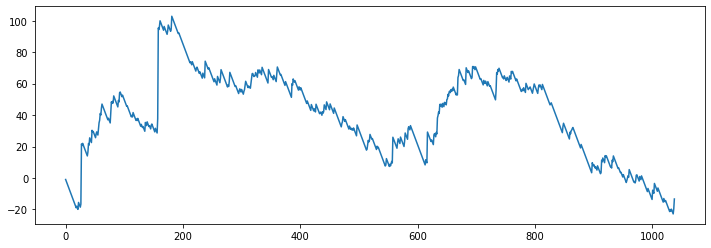

In [15]:
bets['profit'].cumsum().plot(figsize=(12, 4))

In [16]:
bets[['race_id', 'sub_category', 'position', 'final_odds_ref', 'pred', 'winner_dividend', 'placed_dividend', 'profit']]

,race_id,sub_category,position,final_odds_ref,pred,winner_dividend,placed_dividend,profit
0,265,COURSE_A_CONDITIONS,5.0,6.9,0.521440,0.0,0.0,-1.0
1,266,HANDICAP,2.0,15.0,0.158642,0.0,150.0,-1.0
2,267,HANDICAP,8.0,15.0,0.150618,0.0,0.0,-1.0
3,268,COURSE_A_CONDITIONS,6.0,2.3,0.160680,0.0,0.0,-1.0
4,269,COURSE_A_CONDITIONS,8.0,3.5,0.249267,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...
1034,1317,INCONNU,12.0,10.0,0.108951,0.0,0.0,-1.0
1035,1319,AUTOSTART,3.0,1.8,0.217482,0.0,150.0,-1.0
1036,1320,AUTOSTART,8.0,13.0,0.127598,0.0,0.0,-1.0
1037,1321,AUTOSTART,1.0,7.4,0.292368,430.0,160.0,3.3


When you're satisfied with the model, it's time to save it

In [17]:
import os
import shutil
from dill import dump, load

from cataclop.settings import BASE_DIR

model_dir = os.path.join(BASE_DIR, 'var/models/onboarding')

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
else:
    shutil.rmtree(model_dir)
    os.makedirs(model_dir)

path = os.path.join(model_dir, 'models.dill')
dump(models, open(path, 'wb+'))

And we can import it to predict the validation set

In [18]:
import os
import shutil
from dill import dump, load

from cataclop.settings import BASE_DIR

model_dir = os.path.join(BASE_DIR, 'var/models/onboarding')

saved_models = load(open(os.path.join(model_dir, 'models.dill'), 'rb'))

In [19]:
dummies = saved_models[0]['dummies']
pipeline = saved_models[0]['pipeline']

X_val = df_validation[FEATURES]
y_test = df_validation[TARGET]
df_dummies = get_dummy_values(df_validation, dummies)
X_val = pd.concat([X_val, df_dummies], axis=1)

p = pipeline.predict(X_val)

df_validation['pred'] = p

103/103 [==============================] - 0s 3ms/step


In [20]:
random_race(df_validation, ['country', 'name', 'sub_category', 'music', 'position', 'final_odds', 'pred'])

country     name sub_category                     music  \
race_id                                                                
204     2510     FRA  CABOURG      INCONNU    (20)2mDmDm1mDmDaDaDm1m   
        2511     FRA  CABOURG      INCONNU    (20)7a2a6a3a5a6a1a0a0a   
        2512     FRA  CABOURG      INCONNU    (20)0a8m0a8a4a9a9aDa0a   
        2513     FRA  CABOURG      INCONNU  (20)DaDa6m4m0m7aDa(19)2m   
        2514     FRA  CABOURG      INCONNU    (20)0aDa3a3a1aDa1a1a1a   
        2515     FRA  CABOURG      INCONNU    (20)6m7m8a0a9a0a5a4a3a   
        2516     FRA  CABOURG      INCONNU    (20)0aDa1a0a5a0a0a1aDa   
        2517     FRA  CABOURG      INCONNU  (20)DaDm6mDm(19)Dm3m0mDm   
        2518     FRA  CABOURG      INCONNU    (20)4a4a7a5a0a7m1a7a4a   
        2519     FRA  CABOURG      INCONNU  (20)Da0a0aDa0a(19)5m4m4m   
        2520     FRA  CABOURG      INCONNU  (20)9a9aRa(19)Dm8a9a9m0a   
        2521     FRA  CABOURG      INCONNU  (20)DmDm1m8m(19)DmDm8a1m   
        2522     FRA  CABOURG      INCONNU    (20)0m5m8m0m6a8m8m6m3m   
        2523     FRA  CABOURG      INCONNU  (20)DaDa0aRa(19)DmDm7m4m   
        2524     FRA  CABOURG      INCONNU    (20)0aDm1m9m8aDm3mDaDa   
        2525     FRA  CABOURG      INCONNU    (20)DmDm7m0mDm0aDmDa2m   
        2526     FRA  CABOURG      INCONNU    (20)7a0a5a7a5aDa7a3a6a   
        2527     FRA  CABOURG      INCONNU  (20)6m9m0aDm0mRa(19)7m6m   

              position  final_odds      pred  
race_id                                       
204     2510       1.0         3.5  0.069702  
        2511       9.0        77.0  0.066551  
        2512       NaN       208.0  0.025346  
        2513      10.0        59.0  0.023468  
        2514       NaN         4.8  0.043252  
        2515      11.0        38.0  0.066505  
        2516       NaN        40.0  0.035230  
        2517       2.0       151.0  0.039526  
        2518       7.0        18.0  0.078454  
        2519       6.0        67.0  0.041595  
        2520       4.0        26.0  0.042990  
        2521       NaN        10.0  0.027053  
        2522       8.0        30.0  0.050696  
        2523       NaN         4.4  0.033240  
        2524       NaN        11.0  0.034362  
        2525       3.0        56.0  0.036604  
        2526       NaN       147.0  0.051363  
        2527       5.0        60.0  0.033816

Plot the evolution of our bank on the validation set

100%|██████████| 264/264 [00:02<00:00, 101.83it/s]


<AxesSubplot:>

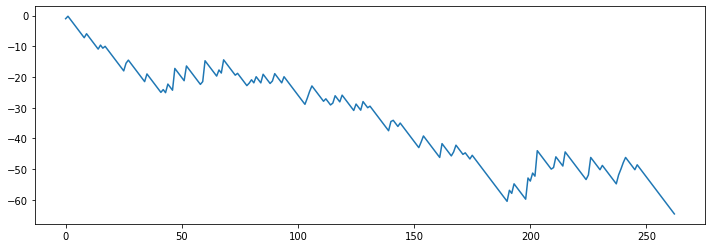

In [21]:
bets_val = bet(df_validation)
bets_val['profit'].cumsum().plot(figsize=(12, 4))